In [52]:
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from numpy.random import default_rng

In [53]:
seed = 0
np.random.seed(seed)

In [54]:
train_file = 'data/OliveOil_TRAIN'

In [55]:
test_file = 'data/OliveOil_TEST'

In [56]:
sampling_rate = 5

# Prep Train Data

In [57]:
train_data = np.loadtxt(train_file)

In [58]:
rng = default_rng(12345)
rng.shuffle(train_data)

In [59]:
X_train = train_data[:,1:]

In [60]:
y_train = train_data[:,0]

In [61]:
print(X_train[0])

[0.130412 0.130675 0.132017 0.133824 0.136095 0.138944 0.141723 0.144136
 0.146431 0.148389 0.149837 0.151585 0.15398  0.156724 0.15945  0.162588
 0.165934 0.169093 0.172397 0.175715 0.179491 0.183787 0.188501 0.193575
 0.198566 0.202986 0.206671 0.209261 0.211073 0.211925 0.211514 0.210548
 0.209608 0.209355 0.209861 0.210734 0.211455 0.211714 0.21137  0.210273
 0.208276 0.205723 0.20332  0.201692 0.200819 0.200697 0.201472 0.201889
 0.201266 0.199871 0.197954 0.196582 0.195869 0.195901 0.196148 0.196098
 0.195735 0.194873 0.194042 0.193285 0.19214  0.190683 0.189272 0.18781
 0.186543 0.185897 0.185932 0.186857 0.188657 0.191872 0.196667 0.202137
 0.207723 0.213356 0.218849 0.224527 0.230611 0.236364 0.24177  0.247225
 0.25281  0.258557 0.264376 0.269652 0.274173 0.277536 0.279723 0.28077
 0.280131 0.278214 0.275684 0.273349 0.271849 0.271867 0.273442 0.275535
 0.277191 0.278099 0.278728 0.279492 0.280641 0.282266 0.284711 0.287662
 0.291062 0.294744 0.298298 0.302238 0.306366 0.31068

In [62]:
print(y_train)

[1. 2. 4. 3. 4. 4. 2. 4. 4. 2. 1. 2. 2. 4. 2. 4. 4. 1. 4. 2. 1. 2. 4. 3.
 3. 1. 4. 4. 3. 4.]


In [63]:
X_train.shape

(30, 570)

In [64]:
y_train.shape

(30,)

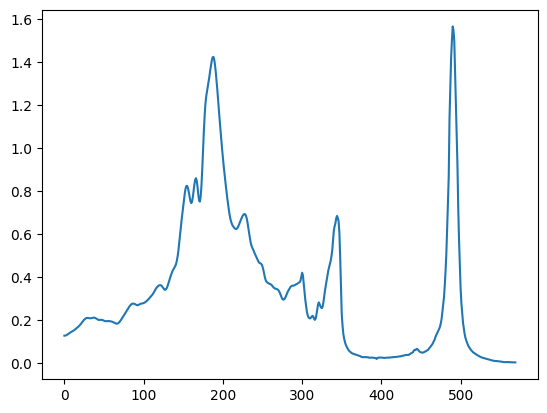

In [65]:
plt.plot(X_train[1])
plt.show()

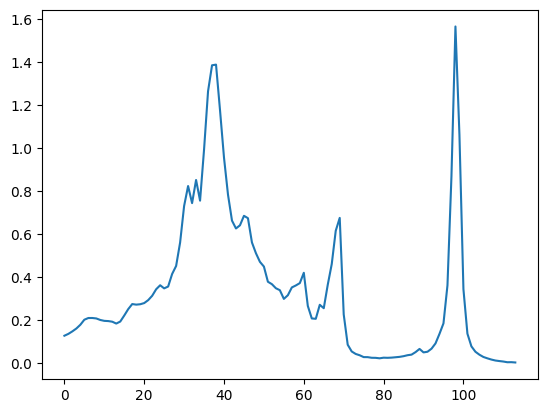

In [66]:
plt.plot(X_train[1, ::sampling_rate])
plt.show()

In [67]:
X_train_sampling = X_train[:, ::sampling_rate]

In [68]:
X_train_sampling.shape

(30, 114)

# Prep Test Data

In [69]:
test_data = np.loadtxt(test_file)

In [70]:
rng = default_rng(12345)
rng.shuffle(test_data)

In [71]:
X_test = test_data[:,1:]

In [72]:
y_test = test_data[:,0]

In [73]:
print(X_test[0])

[0.127523 0.12795  0.129282 0.131174 0.13359  0.136426 0.139358 0.142219
 0.144805 0.146764 0.148192 0.149937 0.152373 0.15505  0.157988 0.160809
 0.1638   0.16725  0.170812 0.174319 0.177914 0.182091 0.186707 0.191972
 0.197008 0.201373 0.205442 0.20848  0.209952 0.210486 0.210038 0.209084
 0.208712 0.208768 0.209268 0.210113 0.211027 0.211241 0.210671 0.209317
 0.207287 0.204825 0.202283 0.200652 0.19995  0.199845 0.20049  0.20086
 0.200056 0.198513 0.196763 0.195297 0.19466  0.194683 0.194877 0.195093
 0.19474  0.193703 0.19262  0.191565 0.190422 0.189213 0.187734 0.18619
 0.184788 0.183765 0.183669 0.184534 0.186481 0.19     0.194675 0.199888
 0.205518 0.211487 0.217381 0.222963 0.228657 0.234344 0.239728 0.245155
 0.250866 0.256754 0.262744 0.268176 0.272617 0.275863 0.277633 0.278133
 0.277478 0.275924 0.273717 0.271731 0.270607 0.270951 0.272717 0.274612
 0.2762   0.277373 0.278297 0.279282 0.280706 0.282665 0.284927 0.28774
 0.291205 0.294984 0.298792 0.302848 0.307245 0.311715

In [74]:
print(y_test[0])

1.0


In [75]:
X_test_sampling = X_test[:, ::sampling_rate]

In [76]:
X_test_sampling.shape

(30, 114)

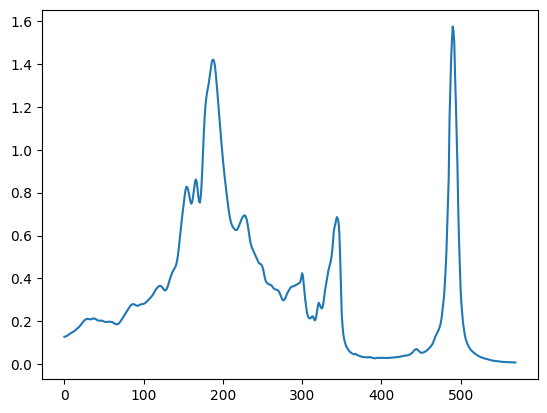

In [77]:
plt.plot(X_test[1])
plt.show()

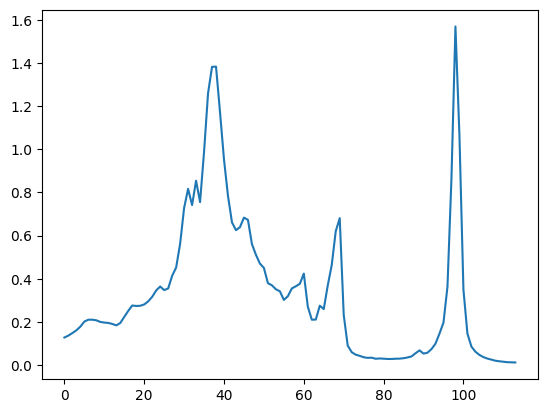

In [78]:
plt.plot(X_test_sampling[0])
plt.show()

# Train Model

In [79]:
def DTW(a, b):
    # ถ้า DTW  ทำช้าอาจต้องทำ sampling เพื่อลดปริมาณ data ทำ DTW จะได้เร็วขึ้น    
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0
    
    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

In [80]:
def DTWWithWeightNeighborCell(a,b,**kwargs):
    # print("weight",kwargs["alpha"],kwargs["beta"],kwargs["gamma"])
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0
    
    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([kwargs["alpha"]*cumdist[ai, bi+1],
                                   kwargs["beta"]*cumdist[ai, bi],
                                   kwargs["gamma"]*cumdist[ai+1, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

# Test Symmetric Model

In [81]:
clf = KNeighborsClassifier(metric =DTW,n_neighbors=1,n_jobs=-1)
clf.fit(X_train_sampling, y_train)

KNeighborsClassifier(metric=<function DTW at 0x00000264E0C04F70>, n_jobs=-1,
                     n_neighbors=1)

In [82]:
y_pred = clf.predict(X_test_sampling)

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.80      0.80      0.80         5
         2.0       0.75      1.00      0.86         9
         3.0       1.00      0.25      0.40         4
         4.0       0.92      0.92      0.92        12

    accuracy                           0.83        30
   macro avg       0.87      0.74      0.74        30
weighted avg       0.86      0.83      0.81        30



# Create Model with weight neighboring cells [Test Asymmetric]

In [84]:
def createMetricParams(alphaMax,betaMax,gammaMax):
    metricParamsArray = []
    for i in range(1,alphaMax+1):
        for j in range(1,betaMax+1):
            for k in range(1,gammaMax+1):
                if (i == k):
                    continue
                metricParam = {"alpha":i,"beta":j,"gamma":k}
                metricParamsArray.append(metricParam)
    return metricParamsArray

In [85]:
createMetricParams(2,2,2)

[{'alpha': 1, 'beta': 1, 'gamma': 2},
 {'alpha': 1, 'beta': 2, 'gamma': 2},
 {'alpha': 2, 'beta': 1, 'gamma': 1},
 {'alpha': 2, 'beta': 2, 'gamma': 1}]

In [86]:
parameters = {'n_neighbors':[1],'metric_params':createMetricParams(5,5,5)}
clf = GridSearchCV(KNeighborsClassifier(metric =DTWWithWeightNeighborCell), parameters, cv=2,verbose=10,n_jobs=-1)
clf.fit(X_train_sampling, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


GridSearchCV(cv=2,
             estimator=KNeighborsClassifier(metric=<function DTWWithWeightNeighborCell at 0x00000264DD79F2E0>),
             n_jobs=-1,
             param_grid={'metric_params': [{'alpha': 1, 'beta': 1, 'gamma': 2},
                                           {'alpha': 1, 'beta': 1, 'gamma': 3},
                                           {'alpha': 1, 'beta': 1, 'gamma': 4},
                                           {'alpha': 1, 'beta': 1, 'gamma': 5},
                                           {'alpha': 1, 'beta': 2, 'gamma': 2},
                                           {'alpha': 1, 'beta': 2, 'gamma': 3},
                                           {'alpha': 1, '...
                                           {'alpha': 1, 'beta': 5, 'gamma': 5},
                                           {'alpha': 2, 'beta': 1, 'gamma': 1},
                                           {'alpha': 2, 'beta': 1, 'gamma': 3},
                                           {'alpha': 2, 'beta': 1, 'gamma': 4},
                                           {'alpha': 2, 'beta': 1, 'gamma': 5},
                                           {'alpha': 2, 'beta': 2, 'gamma': 1},
                                           {'alpha': 2, 'beta': 2, 'gamma': 3},
                                           {'alpha': 2, 'beta': 2, 'gamma': 4},
                                           {'alpha': 2, 'beta': 2, 'gamma': 5},
                                           {'alpha': 2, 'beta': 3, 'gamma': 1},
                                           {'alpha': 2, 'beta': 3, 'gamma': 3}, ...],
                         'n_neighbors': [1]},
             verbose=10)

In [87]:
grid_search_result = clf.cv_results_
grid_search_result_pd = pd.DataFrame.from_dict(grid_search_result)

In [88]:
grid_search_result_pd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric_params,param_n_neighbors,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001494,4.938841e-04,66.111476,0.781995,"{'alpha': 1, 'beta': 1, 'gamma': 2}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.800000,0.800000,0.800000,0.0,1
1,0.002007,2.264977e-06,66.390968,0.966509,"{'alpha': 1, 'beta': 1, 'gamma': 3}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.800000,0.800000,0.800000,0.0,1
2,0.001994,9.988546e-04,65.715977,0.413498,"{'alpha': 1, 'beta': 1, 'gamma': 4}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.800000,0.800000,0.800000,0.0,1
3,0.001509,4.954338e-04,65.296967,0.203489,"{'alpha': 1, 'beta': 1, 'gamma': 5}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.800000,0.800000,0.800000,0.0,1
4,0.001005,9.179115e-06,66.742966,1.217494,"{'alpha': 1, 'beta': 2, 'gamma': 2}",1,"{'metric_params': {'alpha': 1, 'beta': 2, 'gam...",0.333333,0.533333,0.433333,0.1,21
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000999,8.344650e-07,82.175441,0.439644,"{'alpha': 5, 'beta': 4, 'gamma': 4}",1,"{'metric_params': {'alpha': 5, 'beta': 4, 'gam...",0.333333,0.533333,0.433333,0.1,21
96,0.001000,1.072884e-06,51.830376,0.433306,"{'alpha': 5, 'beta': 5, 'gamma': 1}",1,"{'metric_params': {'alpha': 5, 'beta': 5, 'gam...",0.333333,0.533333,0.433333,0.1,21
97,0.001499,4.980564e-04,50.422572,0.228502,"{'alpha': 5, 'beta': 5, 'gamma': 2}",1,"{'metric_params': {'alpha': 5, 'beta': 5, 'gam...",0.333333,0.533333,0.433333,0.1,21
98,0.001497,4.981756e-04,50.366577,0.160504,"{'alpha': 5, 'beta': 5, 'gamma': 3}",1,"{'metric_params': {'alpha': 5, 'beta': 5, 'gam...",0.333333,0.533333,0.433333,0.1,21


In [89]:
grid_search_result_pd[grid_search_result_pd['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric_params,param_n_neighbors,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001494,4.938841e-04,66.111476,0.781995,"{'alpha': 1, 'beta': 1, 'gamma': 2}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.8,0.8,0.8,0.0,1
1,0.002007,2.264977e-06,66.390968,0.966509,"{'alpha': 1, 'beta': 1, 'gamma': 3}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.8,0.8,0.8,0.0,1
2,0.001994,9.988546e-04,65.715977,0.413498,"{'alpha': 1, 'beta': 1, 'gamma': 4}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.8,0.8,0.8,0.0,1
3,0.001509,4.954338e-04,65.296967,0.203489,"{'alpha': 1, 'beta': 1, 'gamma': 5}",1,"{'metric_params': {'alpha': 1, 'beta': 1, 'gam...",0.8,0.8,0.8,0.0,1
20,0.001000,1.192093e-06,69.490052,0.972758,"{'alpha': 2, 'beta': 1, 'gamma': 1}",1,"{'metric_params': {'alpha': 2, 'beta': 1, 'gam...",0.8,0.8,0.8,0.0,1
21,0.001004,9.536743e-07,69.943051,0.555760,"{'alpha': 2, 'beta': 1, 'gamma': 3}",1,"{'metric_params': {'alpha': 2, 'beta': 1, 'gam...",0.8,0.8,0.8,0.0,1
22,0.001003,2.384186e-06,70.394870,0.630578,"{'alpha': 2, 'beta': 1, 'gamma': 4}",1,"{'metric_params': {'alpha': 2, 'beta': 1, 'gam...",0.8,0.8,0.8,0.0,1
23,0.001000,3.337860e-06,70.454632,0.064820,"{'alpha': 2, 'beta': 1, 'gamma': 5}",1,"{'metric_params': {'alpha': 2, 'beta': 1, 'gam...",0.8,0.8,0.8,0.0,1
40,0.000998,1.311302e-06,76.108251,0.137679,"{'alpha': 3, 'beta': 1, 'gamma': 1}",1,"{'metric_params': {'alpha': 3, 'beta': 1, 'gam...",0.8,0.8,0.8,0.0,1
41,0.001499,5.023479e-04,76.502595,0.220292,"{'alpha': 3, 'beta': 1, 'gamma': 2}",1,"{'metric_params': {'alpha': 3, 'beta': 1, 'gam...",0.8,0.8,0.8,0.0,1


In [90]:
model = clf.best_estimator_

In [91]:
print(model.get_params)

<bound method BaseEstimator.get_params of KNeighborsClassifier(metric=<function DTWWithWeightNeighborCell at 0x00000264DD79F2E0>,
                     metric_params={'alpha': 1, 'beta': 1, 'gamma': 2},
                     n_neighbors=1)>


In [92]:
y_pred = model.predict(X_test_sampling)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.83      1.00      0.91         5
         2.0       0.82      1.00      0.90         9
         3.0       1.00      0.25      0.40         4
         4.0       0.92      0.92      0.92        12

    accuracy                           0.87        30
   macro avg       0.89      0.79      0.78        30
weighted avg       0.88      0.87      0.84        30



Dump Best Asym Model

In [93]:
model_file = open('knn_Best_Asym_OliveOil.model', 'wb')
pickle.dump(model, model_file)
model_file.close()

จาก db OliveOil เราจะเห็นว่า Best ของ Asymmetric accuracy ดีกว่า Symmetric